# REINFORCE
### Policy-based RL
- 업데이트의 대상이 정책
- Table형태의 정책 X -> function형태의 정책
- approximate된 정책의 input은 상태벡터, output은 각 행동을 할 확률
    - Discrete한 액션은 행동을 할 확률
    - Continous한 액션은 확률분포
- 확률적으로 행동을 선택(stochastic policy)
- 목적함수 $J(\theta)$ (=performance measure) : 정책에 대한 평가기준이 됨. 
    - 목적함수를 최대로 하는 정책을 습득하는 것
    - $J(\theta)$ : 에피소드 동안 받을 것이라고 기대하는 보상의 합
    
### REINFORCE
- 에피소드마다 업데이트를 수행
- 반환값을 사용하기 때문에 variance가 높음
    - 반환값으로 업데이트의 방향과 크기를 결정함
    
    $$G_t(- \sum y_i log p_i)$$
    
    
### 핵심
- 목적함수의 gradient ascent

$$\theta' = \theta + \alpha \nabla_{\theta} J(\theta)$$


- Policy gradient 수식

$$\nabla_{\theta} J(\theta) = E_{s \sim d_{\pi_{\theta}}, a \sim 
\pi_{\theta}} \big[\nabla_{\theta} log \pi_{\theta} (a|s) q_{\pi_{\theta}}(s, a) \big]$$


- $q_{\pi_{\theta}}(s, a)$를 $q_{\pi_{\theta}}(s, a) \sim G_t$로 근사


$$\nabla_{\theta} J(\theta) \sim \nabla_{\theta} log \pi_{\theta} (A_t|S_t) G_t$$

### 1. Import Libs

In [1]:
import sys
import os
import gym
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

plt.style.use('ggplot')
np.random.seed(123)
EPISODES = 1000

Using TensorFlow backend.


### 2. Define Agent & Model

In [2]:
class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        
        self.model = self.build_model()
        
        self.states = []
        self.actions = []
        self.rewards = []
        
        if self.load_model:
            self.model.load_weights('./save_model/cartpole_reinforce.h5')
            
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform'))
        model.summary()
        
        ### Categorical crossentropy를 사용하는 이유는 pg의 loss를 쉽게 계산하기 때문
        # categorical_crossentropy는 sum(p_i * log(q_i))으로 정의 됨.
        # p_i는 Gt, q_i는 실제 output으로 출력된 policy에서 햔재 행동에 해당하는 확률
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def get_action(self, state):
        # 확률에 따라 행동을 반환하기 위함
        policy = self.model.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    # Gt에 해당하는 return을 구하는 함수
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
    def train_model(self):
        episode_length = len(self.states)
        
        # Gt를 표준정규포화
        discounted_rewards = self.discount_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        
        # input과 Gt를 numpy zeros로 초기화
        # update_inputs = np.zeros((self.state_size, self.state_size)) # 완전 잘못함
        update_inputs = np.zeros((episode_length, self.state_size)) # 에피소드 별 상태
        
        # 각 에피소드의 상태별 action의 Gt들을 담을 그릇
        Gt = np.zeros((episode_length, self.action_size))
        
        # 현재 action에 해당하는 index에 Gt를 넣어주고 곱했을 때 나머지가 0이 되도록함
        for i in range(episode_length): # states의 길이만큼
            update_inputs[i] = self.states[i]
            Gt[i][self.actions[i]] = discounted_rewards[i]
        
        # 학습이후 states, actions, rewards를 초기화
        self.model.fit(update_inputs, Gt, epochs=1, verbose=0)
        self.states, self.actions, self.rewards = [], [], []

### 3. Training

[2018-05-11 20:31:55,510] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
episode :  0   score :  89.0
episode :  1   score :  17.0
episode :  2   score :  40.0
episode :  3   score :  29.0
episode :  4   score :  30.0
episode :  5   score :  28.0
episode :  6   score :  37.0
episode :  7   score :  21.0
episode :  8   score :  11.0
episode :  9   score :  12.0
episode :  10   score :  19.0
episode :  11   score :  12.0
episode :  12   score :  11.0
episode :  13   score :  36.

episode :  243   score :  70.0
episode :  244   score :  78.0
episode :  245   score :  72.0
episode :  246   score :  65.0
episode :  247   score :  242.0
episode :  248   score :  80.0
episode :  249   score :  18.0
episode :  250   score :  118.0
episode :  251   score :  39.0
episode :  252   score :  158.0
episode :  253   score :  212.0
episode :  254   score :  54.0
episode :  255   score :  124.0
episode :  256   score :  41.0
episode :  257   score :  128.0
episode :  258   score :  147.0
episode :  259   score :  31.0
episode :  260   score :  117.0
episode :  261   score :  103.0
episode :  262   score :  221.0
episode :  263   score :  89.0
episode :  264   score :  188.0
episode :  265   score :  74.0
episode :  266   score :  90.0
episode :  267   score :  132.0
episode :  268   score :  150.0
episode :  269   score :  94.0
episode :  270   score :  97.0
episode :  271   score :  106.0
episode :  272   score :  122.0
episode :  273   score :  159.0
episode :  274   score 

episode :  502   score :  226.0
episode :  503   score :  104.0
episode :  504   score :  117.0
episode :  505   score :  285.0
episode :  506   score :  217.0
episode :  507   score :  125.0
episode :  508   score :  148.0
episode :  509   score :  181.0
episode :  510   score :  253.0
episode :  511   score :  209.0
episode :  512   score :  195.0
episode :  513   score :  468.0
episode :  514   score :  209.0
episode :  515   score :  139.0
episode :  516   score :  273.0
episode :  517   score :  153.0
episode :  518   score :  266.0
episode :  519   score :  117.0
episode :  520   score :  86.0
episode :  521   score :  84.0
episode :  522   score :  68.0
episode :  523   score :  48.0
episode :  524   score :  92.0
episode :  525   score :  106.0
episode :  526   score :  127.0
episode :  527   score :  112.0
episode :  528   score :  133.0
episode :  529   score :  50.0
episode :  530   score :  77.0
episode :  531   score :  95.0
episode :  532   score :  143.0
episode :  533  

episode :  760   score :  145.0
episode :  761   score :  21.0
episode :  762   score :  159.0
episode :  763   score :  114.0
episode :  764   score :  132.0
episode :  765   score :  12.0
episode :  766   score :  138.0
episode :  767   score :  127.0
episode :  768   score :  123.0
episode :  769   score :  146.0
episode :  770   score :  121.0
episode :  771   score :  138.0
episode :  772   score :  136.0
episode :  773   score :  136.0
episode :  774   score :  121.0
episode :  775   score :  130.0
episode :  776   score :  111.0
episode :  777   score :  137.0
episode :  778   score :  134.0
episode :  779   score :  130.0
episode :  780   score :  133.0
episode :  781   score :  136.0
episode :  782   score :  138.0
episode :  783   score :  155.0
episode :  784   score :  157.0
episode :  785   score :  172.0
episode :  786   score :  203.0
episode :  787   score :  234.0
episode :  788   score :  274.0
episode :  789   score :  310.0
episode :  790   score :  295.0
episode : 

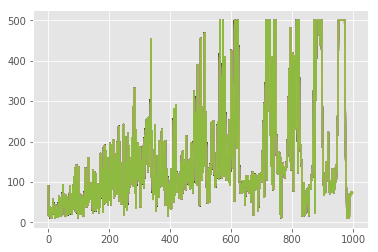

In [3]:
graph_path = os.path.join(os.getcwd(), 'save_graph')
model_path = os.path.join(os.getcwd(), 'save_model')

if not os.path.isdir(graph_path):
    os.mkdir(graph_path)    
if not os.path.isdir(model_path):
    os.mkdir(model_path)

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# 에이전트 생성
agent = REINFORCEAgent(state_size, action_size)
scores, episodes = [], []

# 에피소드마다 학습함
for episode in range(EPISODES):
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    while True:
        if agent.render:
            env.render()
        
        # 1. 행동정책을 step단위로 수행하여 sampling
        # 2. 학습을 episode 단위로 수행
        
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        reward = reward if not done or score == 499 else -100
        
        # 한 에피소드 동안 지속적으로 샘플을 획득함. 업데이트는 에피소드가 끝난 이후
        agent.append_sample(state, action, reward)
        score += reward
        state = next_state
        
        if done:
            agent.train_model()
            
            # 500을 채우지 못하고 끝난 경우 -100을 해준 것을 제외하고 점수를 저장
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(episode)
            plt.plot(episodes, scores)
            plt.savefig('./save_graph/cartpole_reinforce.png')
            print("episode : ", episode, "  score : ", score)
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                agent.model.save_weights("./save_model/cartpole_reinforce.h5")
            break
            
    if episode % 50 == 0:
        agent.model.save_weights("./save_model/cartpole_reinforce.h5")